In [1]:
import torch
def tensor_repr(x):
    tmp = f"{x.type()}"
    tmp +=  "[" + ','.join([str(s) for s in x.shape]) + "]"
    if x.dim() == 0:
        tmp += f", {x.item()}"
    return tmp

torch.Tensor.__repr__ = tensor_repr


x = torch.randn(2, 3, 480, 640)

In [2]:
from torchvision.models.segmentation._utils import _SimpleSegmentationModel


class SmallDeepLab(_SimpleSegmentationModel):
    def forward(self, x):
        features = self.backbone(x)
        # print("features :", features)
        x = features["out"]
        return features["res2"], self.classifier(x)

    
from torchvision.models.resnet import resnet50, resnet101
from torchvision.models._utils import IntermediateLayerGetter
from torchvision.models.utils import load_state_dict_from_url
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.models.segmentation.fcn import FCNHead


net = SmallDeepLab(
    backbone=IntermediateLayerGetter(
        resnet101(pretrained=True, replace_stride_with_dilation=[False, True, True]),
        return_layers={'layer2':'res2', 'layer4': 'out'}
    ),
    classifier=DeepLabHead(2048, 21),
    aux_classifier = FCNHead(1024, 21)
)

state_dict = load_state_dict_from_url('https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth', progress=True)
net.load_state_dict(state_dict)
net.eval()
print("Done")

Done


In [3]:
# Download an example image from the pytorch website
url = "https://github.com/pytorch/hub/raw/master/dog.jpg"
filename = "dog.jpg"
import urllib
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)
    
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms


input_image = Image.open(filename)
input_image = input_image.resize((2048, 1024))
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
img = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
img

torch.FloatTensor[1,3,1024,2048]

In [4]:
with torch.no_grad():
    res2, out = net(img)
    
res2, out

(torch.FloatTensor[1,512,128,256], torch.FloatTensor[1,21,128,256])

<Figure size 432x288 with 0 Axes>

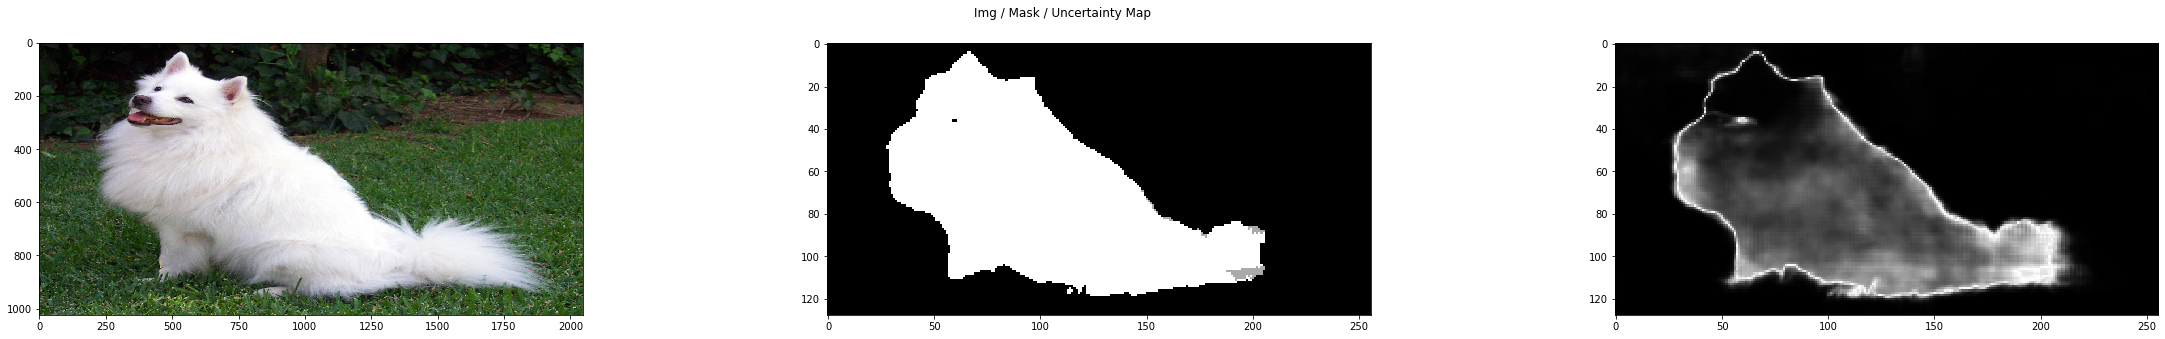

In [5]:
import matplotlib.pyplot as plt


with torch.no_grad():
    plt.figure()
    fig, ax = plt.subplots(1, 3, figsize=(40, 5))
    fig.suptitle("Img / Mask / Uncertainty Map")
    # softmax for normalize
    pred = out.softmax(1).argmax(1).float()
    
    """
    In Paper,
    To measure prediction uncertainty
    we use the same strategy during training and inference:
    the difference between the most confident
    and second most confident class probabilities
    """
    v, i = out.softmax(1).sort(1, descending=True)
    # uncertainty = (v[:, -1, :, :] - v[:, -2, :, :]) <= 0.5
    uncertainty = - (v[:, 0, :, :] - v[:, 1, :, :])
    
    ax[0].imshow(input_image)
    ax[1].imshow(pred[0].numpy(), cmap="gray")
    ax[2].imshow(uncertainty[0].numpy(), cmap="gray")
    plt.show()

In [31]:
def plot(img, title, targets=None, s=0.5):
    if targets is None:
        plt.figure()
        plt.title(title)
        plt.imshow(img, cmap="gray")
        return

    fig, ax = plt.subplots(1, len(targets), figsize=(30*len(targets), 15))
    if len(targets) == 1:
        ax = [ax]
    fig.suptitle(title, fontsize=60)
    
    def scatter(ax_, p, c, s):
        if len(p) == 0:
            return
        H, W = img.shape[-2:]
        p = p[0].numpy()  # Remove Batch
        ax_.scatter(p % W, p // W, c=c, s=s)

    for i, (ax_title, points) in enumerate(targets.items()): 
        i_p, c_p = points
        ax[i].set_title(ax_title)
        ax[i].imshow(img, cmap="gray")
        scatter(ax[i], i_p, "red", s)
        scatter(ax[i], c_p, "yellow", s)


import torch


@torch.no_grad()
def sampling_points(mask, k=3, beta=0.75, training=True):
    """
    Args:
        mask(Tensor): [B, C, H, W]

    Return:
        selected_point(Tensor) : flattened indexing points [B, num_points]
    """
    assert mask.dim() == 4, "Dim must be N(Batch)CHW"
    device = mask.device
    v, _ = mask.softmax(1).sort(1, descending=True)
    # When Values bigger getting more Uncertainty
    uncertainty_map = -1 * (v[:, 0, :, :] - v[:, 1, :, :])

    B, H, W = uncertainty_map.shape
    # Num of points
    N = H * W

    over_generation = torch.randint(N, (B, k * N), dtype=torch.long, device=device)
    over_generation_map = torch.gather(uncertainty_map.view(B, N), 1, over_generation).view(B, -1)

    # most uncertain βN points
    _, idx = over_generation_map.topk(int(beta * N))
    importance = torch.gather(over_generation, 1, idx)

    coverage = torch.randint(N, (B, int((1 - beta) * N)), dtype=torch.long, device=device)
    
    return importance, coverage
    # return torch.cat([importance, coverage], dim=1)


In [32]:
i_p, c_p = sampling_points(out, 10, 0.75)

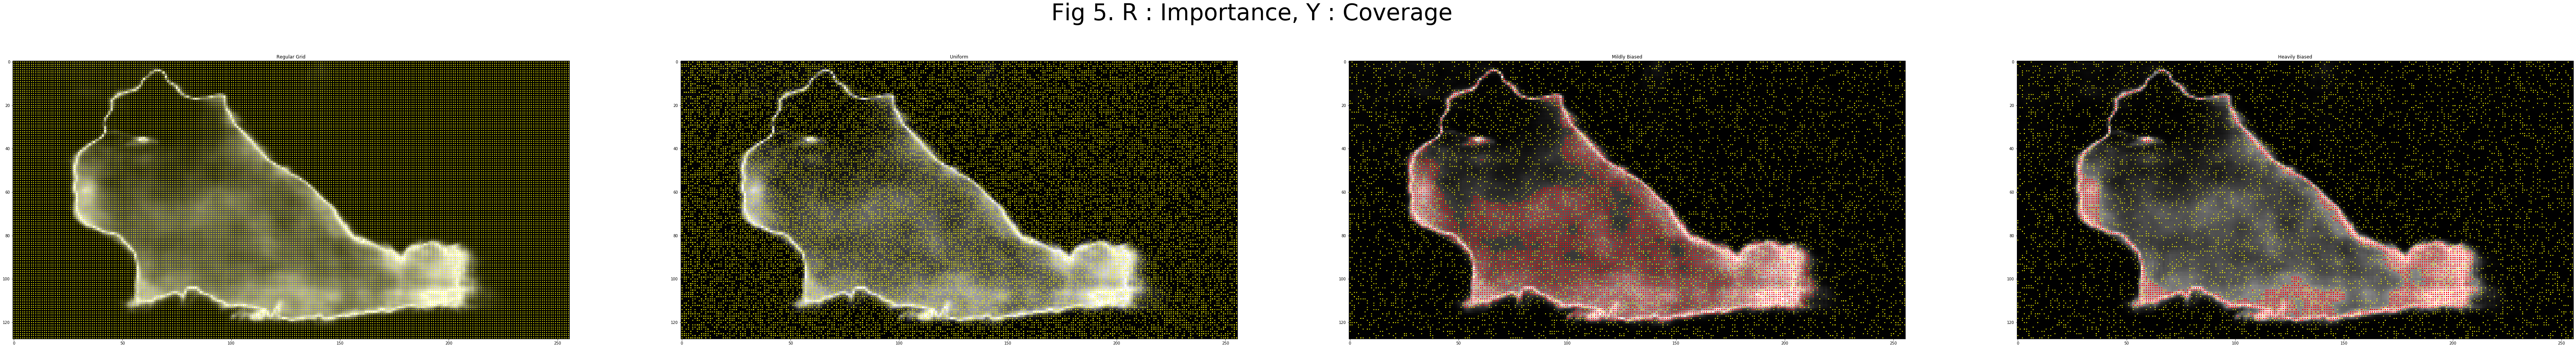

In [33]:
import numpy as np

title = "Fig 5. R : Importance, Y : Coverage"

B, _, H, W = out.shape
plot_points = {
    "Regular Grid": ([], torch.arange(B * H * W).view(B, -1)),
    "Uniform": sampling_points(out, 1, 0),
    "Mildly Biased": sampling_points(out, 3, 0.75),
    "Heavily Biased": sampling_points(out, 10, 0.75)
}

plot(uncertainty[0].numpy(), title, plot_points, s=2.4)